In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.linear_solver import pywraplp
import random
pd.options.display.max_rows = 5000
pd.options.display.max_columns = 500

In [169]:
###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['ml_outcomes'] = df['ml_outcomes_div'].round(2)# + df['R']*0.13


In [170]:
df['ml_outcomes'].describe()

count    1000000.000000
mean           0.523725
std            0.198167
min            0.020000
25%            0.380000
50%            0.510000
75%            0.660000
max            1.230000
Name: ml_outcomes, dtype: float64

In [171]:
df['T']

0         62
1         53
2         60
3         42
4         40
          ..
999995    71
999996    48
999997    47
999998    50
999999    46
Name: T, Length: 1000000, dtype: int64

In [172]:
FRAC_ADMIT = df[['A']].sum()/len(df)


In [173]:
FRAC_ADMIT

A    0.485361
dtype: float64

In [174]:
len(df)

1000000

<AxesSubplot:>

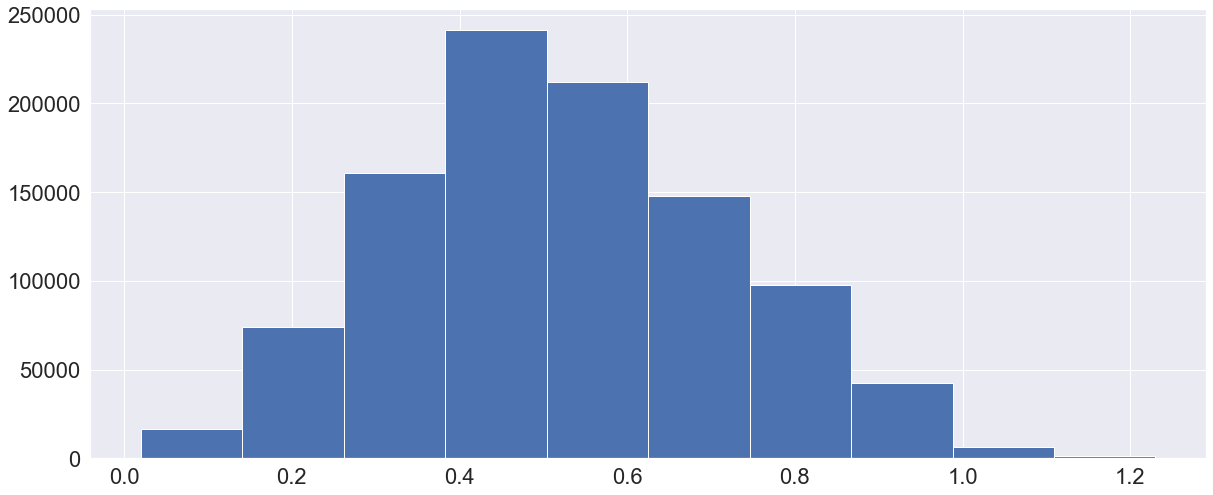

In [175]:
df['ml_outcomes'].hist()

In [176]:
##
# R = race, T = test score, ml_outcomes = expected utility from admitting, 
# ml_outcomes_{} counterfactual utility given race 
##

df[['R','T','ml_outcomes','T_black','T_white','ml_outcomes_black','ml_outcomes_white','ml_outcomes_decision','B_p']].sort_values(by='ml_outcomes')



,R,T,ml_outcomes,T_black,T_white,ml_outcomes_black,ml_outcomes_white,ml_outcomes_decision,B_p
799856,0,7,0.02,6,7,-4.079949,-3.784626,0,0
381520,0,8,0.02,6,8,-4.079949,-3.705448,0,0
802371,0,12,0.03,10,12,-3.763237,-3.388736,0,0
475990,0,10,0.03,7,10,-4.000771,-3.547092,0,0
195611,0,12,0.03,7,12,-4.000771,-3.388736,0,0
...,...,...,...,...,...,...,...,...,...
774157,1,106,1.23,106,124,3.837851,5.479200,1,1
733667,1,108,1.23,108,126,3.996207,5.637556,1,1
777126,1,104,1.23,104,121,3.679495,5.241666,1,1
961510,1,105,1.23,105,123,3.758673,5.400022,1,1


In [177]:
###
## Get total utility from admitting people in a stratum 
###

df_ = df[['R','T','ml_outcomes']].groupby(['R','T']).sum().reset_index()

In [178]:
###
## Get number of people in each stratum
###

df_count = df[['R','T','ml_outcomes']].groupby(['R','T']).count().reset_index()
df_count.columns = ['R','T','Count']
df_count['N'] = df_count['Count']

In [179]:
###
## Get boards passage probability in each stratum
###

df_prob = df[['R','T','B_p']].groupby(['R','T']).mean().reset_index()
df_prob.columns = ['R','T','ml_outcomes_prob']

#df_prob = df[['R','T','ml_outcomes_prob']]

In [180]:
###
## Merge summary tables to get one table with Race, Test Score, SUM(Utility), COUNT(applicants), E(Y(1)|X )
###

dff = df_.merge(df_count[['N']],left_index=True,right_index=True)
dff = dff.merge(df_prob[['ml_outcomes_prob']],left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False).reset_index().sort_values(by='index').reset_index()



In [181]:
# final info table
dff.sort_values(by='ml_outcomes_prob')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob
0,225,0,0,7,0.02,1,0.000000
123,215,123,1,7,0.54,2,0.000000
124,218,124,1,8,0.27,1,0.000000
127,201,127,1,11,1.89,7,0.000000
128,196,128,1,12,2.52,9,0.000000
129,188,129,1,13,4.48,16,0.000000
122,219,122,1,4,0.26,1,0.000000
223,203,223,1,107,1.23,1,0.000000
5,220,5,0,12,0.15,5,0.000000
7,216,7,0,14,0.44,11,0.000000


In [182]:
dff['Pr(X=X_j)'] = dff['N']/(dff['N']).sum()

In [183]:
dff[dff['R']==1].sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j)
122,219,122,1,4,0.26,1,0.000000,0.000001
123,215,123,1,7,0.54,2,0.000000,0.000002
124,218,124,1,8,0.27,1,0.000000,0.000001
125,214,125,1,9,0.54,2,0.500000,0.000002
126,193,126,1,10,2.97,11,0.090909,0.000011
127,201,127,1,11,1.89,7,0.000000,0.000007
128,196,128,1,12,2.52,9,0.000000,0.000009
129,188,129,1,13,4.48,16,0.000000,0.000016
130,178,130,1,14,7.84,28,0.071429,0.000028
131,169,131,1,15,14.00,50,0.060000,0.000050


In [184]:
df_decisions = None
max_utility = -1.0

for C_y in np.linspace(0.0,1.0,10001):
    dff['alpha_j'] = dff['Pr(X=X_j)']* (dff['ml_outcomes_prob'] - C_y)
    solver = pywraplp.Solver.CreateSolver('GLOP')

    
    applicant_stratum = []
    vars_cache = {}
    alpha_j = {}
    
    # Objective: Maximize the expected utility of the admitted students
    objective = solver.Objective()
    
    # For each stratum
    for ix, row in dff.iterrows():
        # probability of admission
        numvar = solver.NumVar(0.0, 1.0, str(ix))
        
        # store variable by index, and also by stratum R, T
        applicant_stratum.append(numvar)
        vars_cache[(row['R'],row['T'])] = numvar
        
        alpha_j[(row['R'],row['T'])] = row['alpha_j']
        
        # Benefit of admitting people is total utility in that stratum
        objective.SetCoefficient(applicant_stratum[ix], float(row['ml_outcomes']))
        
    objective.SetMaximization()

    # Constraint: At most K applicants
    K = int(len(df)*FRAC_ADMIT)
    admit_quota = solver.Constraint(0, K)
    
    # Total admits cannot exceed K 
    for ix, row in dff.iterrows():
        admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))
    
    
    sum_alpha = 0
    R = 1 
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_black = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_black.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )    
    
    sum_alpha = 0
    R = 0
    
    for T in list(dff[dff['R']==R]['T']):
        sum_alpha+= alpha_j[(R,T)] 
        
    cf_white = solver.Constraint(sum_alpha, sum_alpha)
    
    for T in list(dff[dff['R']==R]['T']):    
        cf_white.SetCoefficient(vars_cache[(R,T)], alpha_j[(R,T)] )
        
    status = solver.Solve()

    if status != 2:
        TOTAL_UTILITY = 0
        for ix, row in dff.iterrows():
            TOTAL_UTILITY += float(row['ml_outcomes'])* vars_cache[(row['R'],row['T'])].solution_value()
        print(C_y,TOTAL_UTILITY)
        
        if TOTAL_UTILITY > max_utility:
            row = []
            admit = []
        
            for i in applicant_stratum:
                row.append(int(str(i)))
                admit.append(i.solution_value())
            
            df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
            
            max_utility = TOTAL_UTILITY


0.2765 309361.80442184553
0.2766 309368.9803503331
0.2767 309374.6637434132
0.2768 309380.0292624994
0.27690000000000003 309385.4828309088
0.277 309390.8703339708
0.2771 309396.3520936237
0.2772 309401.79728845943
0.2773 309406.9013372523
0.27740000000000004 309412.1001095272
0.2775 309417.39386314776
0.2776 309422.78285691433
0.2777 309428.26735056797
0.2778 309433.8476047965
0.27790000000000004 309439.52388123656
0.278 309445.29644247744
0.2781 309451.1655520692
0.2782 309457.13147452316
0.2783 309463.1944753178
0.27840000000000004 309469.354820904
0.2785 309475.57135895005
0.2786 309481.8808003808
0.2787 309488.288418884
0.2788 309494.7944849165
0.27890000000000004 309501.3992699271
0.279 309508.1030463652
0.2791 309514.90608768427
0.2792 309521.8086683431
0.2793 309528.81106381596
0.27940000000000004 309535.9135505932
0.2795 309543.11640618794
0.2796 309550.4199091396
0.2797 309557.8243390187
0.2798 309565.32997643447
0.27990000000000004 309572.9371030342
0.28 309580.6460015136
0.2

0.3054 310098.85545222525
0.3055 310100.9899331562
0.30560000000000004 310103.1966433797
0.3057 310105.4757351738
0.3058 310107.77637948573
0.3059 310110.10884114535
0.306 310112.5140703725
0.30610000000000004 310114.99222101225
0.3062 310117.5434473441
0.3063 310120.16790408373
0.3064 310122.865746382
0.3065 310125.6371298298
0.30660000000000004 310128.4822104582
0.30670000000000003 310131.40114473976
0.3068 310134.3940895899
0.3069 310137.46120236925
0.307 310140.6026408845
0.30710000000000004 310143.81856339105
0.30720000000000003 310147.10912859335
0.3073 310150.4744956472
0.3074 310153.91482416115
0.3075 310157.43027419783
0.30760000000000004 310161.0210062769
0.30770000000000003 310164.6871813747
0.3078 310168.42896092695
0.3079 310172.24650683097
0.308 310176.13998144603
0.30810000000000004 310180.10954759555
0.30820000000000003 310184.1553685695
0.3083 310188.2776081247
0.3084 310192.47643048764
0.3085 310196.75200035534
0.30860000000000004 310201.104482898
0.30870000000000003 

0.33430000000000004 311080.5936957947
0.33440000000000003 311082.05011416617
0.3345 311083.5688270811
0.3346 311085.1499478349
0.3347 311086.7935899977
0.33480000000000004 311088.4998674147
0.33490000000000003 311090.2581490713
0.335 311092.0647446473
0.3351 311093.93430708454
0.3352 311095.8669513188
0.33530000000000004 311097.86196575355
0.33540000000000003 311099.88758684346
0.3355 311101.97664616135
0.3356 311104.1292597863
0.3357 311106.34554408013
0.33580000000000004 311108.6256156892
0.33590000000000003 311110.9695915454
0.336 311113.377588866
0.3361 311115.84972515545
0.3362 311118.38611820585
0.33630000000000004 311120.98688609735
0.33640000000000003 311123.652147201
0.3365 311126.382020177
0.3366 311129.17662397714
0.3367 311132.0360778455
0.33680000000000004 311134.960501319
0.33690000000000003 311137.95001422917
0.337 311141.0047367015
0.3371 311144.12478915753
0.3372 311147.31029231625
0.3373 311150.5613671934
0.33740000000000003 311153.87813510344
0.3375 311157.2607176604

0.3627 311829.26585345966
0.3628 311828.39550559316
0.3629 311827.574793695
0.36300000000000004 311826.80379186256
0.36310000000000003 311826.0825743404
0.3632 311825.4112155212
0.3633 311824.78978994576
0.3634 311824.218372304
0.3635 311823.69569854194
0.36360000000000003 311823.22283010924
0.3637 311822.80019415525
0.3638 311822.4278659668
0.3639 311822.10592098214
0.364 311821.8344347893
0.36410000000000003 311821.61348312936
0.3642 311821.4431418932
0.3643 311821.2957447113
0.3644 311821.19534110173
0.3645 311821.14569875476
0.36460000000000004 311821.1468940557
0.3647 311821.1990035431
0.3648 311821.3021039089
0.3649 311821.4562719995
0.365 311821.66158481553
0.36510000000000004 311821.91811951296
0.3652 311822.2259534023
0.3653 311822.5851639504
0.3654 311822.9958287801
0.3655 311823.45802567
0.36560000000000004 311823.97183255653
0.3657 311824.53732753254
0.3658 311825.15458884934
0.3659 311825.823694915
0.366 311826.5447242973
0.36610000000000004 311827.317755722
0.3662 311828.

0.3914 311950.0557726649
0.3915 311947.9368937842
0.3916 311945.8594593992
0.3917 311943.8207169281
0.39180000000000004 311941.8242223437
0.3919 311939.87003057625
0.392 311937.9581966519
0.3921 311936.08877569117
0.3922 311934.26182291145
0.39230000000000004 311932.4773936249
0.3924 311930.7355432406
0.3925 311929.0363272637
0.3926 311927.37980129564
0.3927 311925.7660210349
0.39280000000000004 311924.1950422768
0.3929 311922.6669209137
0.393 311921.1817129354
0.3931 311919.73947442917
0.3932 311918.34026158013
0.39330000000000004 311916.9841306718
0.3934 311915.671138085
0.3935 311914.4013402999
0.3936 311913.17479389475
0.3937 311911.9915555467
0.39380000000000004 311910.8516820324
0.39390000000000003 311909.75523022737
0.394 311908.7022571062
0.3941 311907.69281974493
0.3942 311906.72697531723
0.39430000000000004 311905.8047810985
0.39440000000000003 311904.92629446415
0.3945 311904.09157289
0.3946 311903.30067395285
0.3947 311902.5536553305
0.39480000000000004 311901.85057480185
0

0.41910000000000003 309782.02525559254
0.4192 309732.88334173115
0.4193 309683.74142779806
0.4194 309634.5411306603
0.41950000000000004 309585.0388636699
0.41960000000000003 309535.475005979
0.4197 309485.9111482137
0.4198 309436.3472903738
0.4199 309386.7834324598
0.42000000000000004 309337.2195744715
0.42010000000000003 309287.65571640903
0.4202 309238.0918582723
0.4203 309188.5280000617
0.4204 309138.9641417771
0.42050000000000004 309089.40028341836
0.42060000000000003 309039.83642498596
0.4207 308990.2725664797
0.4208 308940.7045084977
0.4209 308891.1228465002
0.42100000000000004 308841.54118442914
0.42110000000000003 308791.95952228445
0.4212 308742.3778600661
0.4213 308692.7961977744
0.4214 308643.2145354095
0.42150000000000004 308593.6328729713
0.42160000000000003 308544.0512104595
0.4217 308494.4695478748
0.4218 308444.8485993509
0.4219 308395.22082244133
0.42200000000000004 308345.5930454586
0.42210000000000003 308295.9652684028
0.4222 308246.33749127394
0.4223 308196.70971407

0.44730000000000003 295623.8715126486
0.4474 295572.91217306524
0.4475 295521.9528334189
0.4476 295470.99349371076
0.44770000000000004 295420.03415393987
0.44780000000000003 295369.0748141069
0.4479 295318.11547421175
0.448 295267.15613425453
0.4481 295216.19679423503
0.44820000000000004 295165.2374541536
0.44830000000000003 295114.27811401006
0.4484 295063.31877380464
0.4485 295012.35943353723
0.4486 294961.4000932082
0.44870000000000004 294910.44075281697
0.44880000000000003 294859.4814123641
0.4489 294808.5220718497
0.449 294757.5627312738
0.4491 294706.6033906361
0.44920000000000004 294655.64255030645
0.44930000000000003 294604.6794340994
0.4494 294553.7151494277
0.4495 294502.7501396945
0.4496 294451.7851299
0.44970000000000004 294400.82012004405
0.44980000000000003 294349.855110127
0.4499 294298.8806005086
0.45 294247.7919115646
0.4501 294196.7032225592
0.45020000000000004 294145.61453349236
0.45030000000000003 294094.52584436414
0.4504 294043.43715517485
0.4505 293992.3484659244

0.47440000000000004 281734.5109396661
0.47450000000000003 281683.1523190868
0.4746 281631.7936984562
0.4747 281580.4350777746
0.4748 281529.07645704166
0.47490000000000004 281477.71783625823
0.47500000000000003 281426.3592154233
0.4751 281375.0005945379
0.4752 281323.6419736014
0.4753 281272.28335261426
0.47540000000000004 281220.9247315762
0.47550000000000003 281169.56611048745
0.4756 281118.20748934813
0.4757 281066.848868158
0.4758 281015.49024691747
0.47590000000000005 280964.131625626
0.47600000000000003 280912.7730042841
0.4761 280861.4143828921
0.4762 280810.05576144904
0.4763 280758.6971399558
0.47640000000000005 280707.33851841226
0.47650000000000003 280655.97989681823
0.4766 280604.62127517397
0.4767 280553.26265347947
0.4768 280501.90403173486
0.47690000000000005 280450.5454099398
0.47700000000000004 280399.18678809475
0.4771 280347.8281661994
0.4772 280296.46954425407
0.4773 280245.11092225875
0.47740000000000005 280193.75230021344
0.47750000000000004 280142.39367811824
0.4

0.5019 267575.8527463518
0.502 267524.2699497759
0.5021 267472.6871531681
0.5022 267421.10435652814
0.5023 267369.5215598566
0.5024000000000001 267317.9305194727
0.5025000000000001 267266.2361719718
0.5026 267214.54182443913
0.5027 267162.8474768748
0.5028 267111.1531292786
0.5029 267059.45878165093
0.503 267007.7644339912
0.5031 266956.0700862998
0.5032 266904.3757385763
0.5033 266852.6813908212
0.5034000000000001 266800.9870430341
0.5035000000000001 266749.2926952151
0.5036 266697.5983473643
0.5037 266645.89208799024
0.5038 266594.1840996432
0.5039 266542.4761112644
0.504 266490.76812285313
0.5041 266439.0601344103
0.5042 266387.3521459354
0.5043 266335.64415742835
0.5044000000000001 266283.9361688892
0.5045000000000001 266232.22818031814
0.5046 266180.5201917151
0.5047 266128.81220307975
0.5048 266077.10421441233
0.5049 266025.39622571284
0.505 265973.68823698116
0.5051 265921.98024821724
0.5052 265870.2722594212
0.5053 265818.56427059276
0.5054000000000001 265766.8562817323
0.50550

0.531 252459.0539370677
0.5311 252406.78027713962
0.5312 252354.50661717475
0.5313 252302.23295717282
0.5314 252249.9592971337
0.5315 252197.68563705773
0.5316000000000001 252145.41197694454
0.5317000000000001 252093.1383167945
0.5318 252040.86465660713
0.5319 251988.59099638276
0.532 251936.3173361213
0.5321 251884.0436758225
0.5322 251831.77001548675
0.5323 251779.49635511378
0.5324 251727.22269470323
0.5325 251674.94903425564
0.5326000000000001 251622.67537377073
0.5327000000000001 251570.40171324866
0.5328 251518.124250612
0.5329 251465.84623108793
0.533 251413.5682115269
0.5331 251361.29019192822
0.5332 251309.0121722922
0.5333 251256.7341526187
0.5334 251204.4561329076
0.5335 251152.1781131592
0.5336000000000001 251099.90009337311
0.5337000000000001 251047.6220735496
0.5338 250995.3440536884
0.5339 250943.06603378983
0.534 250890.78801385345
0.5341 250838.5099938794
0.5342 250786.23197386807
0.5343 250733.95395381874
0.5344 250681.67593373146
0.5345 250629.312953985
0.53460000000

0.5602 236925.31567918925
0.5603 236871.4068647039
0.5604 236817.4980501786
0.5605 236763.58923561324
0.5606 236709.6804210078
0.5607 236655.77160636222
0.5608000000000001 236601.86279167683
0.5609000000000001 236547.92631233434
0.561 236493.94599599202
0.5611 236439.96567960986
0.5612 236385.98536318753
0.5613 236332.00504672516
0.5614 236278.02473022285
0.5615 236224.0444136806
0.5616 236170.06409709822
0.5617 236116.08378047546
0.5618000000000001 236062.1034638127
0.5619000000000001 236008.12314710958
0.562 235954.14283036639
0.5621 235900.16251358326
0.5622 235846.18219675944
0.5623 235792.20187989567
0.5624 235738.2215629913
0.5625 235684.24124604693
0.5626 235630.26092906215
0.5627 235576.28061203682
0.5628000000000001 235522.30029497086
0.5629000000000001 235468.319977865
0.5630000000000001 235414.33966071825
0.5631 235360.3593435309
0.5632 235306.3790263033
0.5633 235252.3987090352
0.5634 235198.4183917264
0.5635 235144.438074377
0.5636 235090.45775698646
0.5637 235036.47743955

0.5894 216394.0328274743
0.5895 216291.84139847933
0.5896 216189.6928553663
0.5897 216087.5871438108
0.5898 215985.52420957736
0.5899 215883.50399852404
0.5900000000000001 215781.52645659857
0.5901000000000001 215679.59152984188
0.5902000000000001 215577.63034965162
0.5903 215475.64757529128
0.5904 215373.70731129555
0.5905 215271.8095039956
0.5906 215169.95409981275
0.5907 215068.14104525835
0.5908 214966.37028693376
0.5909 214864.64177153044
0.5910000000000001 214762.9554458286
0.5911000000000001 214661.31125669865
0.5912000000000001 214559.70915109967
0.5913 214458.14907607995
0.5914 214356.6309787759
0.5915 214255.15480641375
0.5916 214153.72050630735
0.5917 214052.32802585876
0.5918 213950.97731255877
0.5919 213849.6683139849
0.5920000000000001 213748.40097780366
0.5921000000000001 213647.17525176826
0.5922000000000001 213545.99108371913
0.5923 213444.84515465453
0.5924 213343.6516698233
0.5925 213242.49962558734
0.5926 213141.38897008612
0.5927 213040.319651546
0.5928 212939.2916

## Add CF Predictive Parity Constraints

In [185]:
df_decisions

,row_id,decision
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.000000
6,6,0.000000
7,7,0.000000
8,8,0.000000
9,9,0.000000


In [186]:
dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
51,0,51,0,58,11123.28,19863,0.563963,0.019863,-8.661000e-03,51,0.000000
50,1,50,0,57,11087.82,20533,0.539035,0.020533,-9.465000e-03,50,0.000000
53,2,53,0,60,11038.80,18398,0.601424,0.018398,-7.333000e-03,53,1.000000
52,3,52,0,59,11026.38,19011,0.588396,0.019011,-7.825000e-03,52,0.002516
49,4,49,0,56,10957.96,21073,0.527927,0.021073,-9.948000e-03,49,0.000000
54,5,54,0,61,10879.76,17548,0.622635,0.017548,-6.622000e-03,54,1.000000
55,6,55,0,62,10686.72,16698,0.638280,0.016698,-6.040000e-03,55,1.000000
48,7,48,0,55,10626.50,21253,0.499553,0.021253,-1.063600e-02,48,0.000000
47,8,47,0,54,10265.76,21387,0.486136,0.021387,-1.099000e-02,47,0.000000
56,9,56,0,63,10252.44,15534,0.648513,0.015534,-5.460000e-03,56,1.000000


In [187]:
xxx_ = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx_.sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
122,219,122,1,4,0.26,1,0.000000,0.000001,-1.000000e-06,122,1.000000
0,225,0,0,7,0.02,1,0.000000,0.000001,-1.000000e-06,0,0.000000
123,215,123,1,7,0.54,2,0.000000,0.000002,-2.000000e-06,123,1.000000
124,218,124,1,8,0.27,1,0.000000,0.000001,-1.000000e-06,124,1.000000
1,224,1,0,8,0.02,1,0.000000,0.000001,-1.000000e-06,1,0.000000
2,221,2,0,9,0.06,2,0.000000,0.000002,-2.000000e-06,2,0.000000
125,214,125,1,9,0.54,2,0.500000,0.000002,-1.000000e-06,125,0.000000
3,223,3,0,10,0.03,1,0.000000,0.000001,-1.000000e-06,3,0.000000
126,193,126,1,10,2.97,11,0.090909,0.000011,-1.000000e-05,126,0.000000
127,201,127,1,11,1.89,7,0.000000,0.000007,-7.000000e-06,127,1.000000


In [188]:
xxx = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
51,0,51,0,58,11123.28,19863,0.563963,0.019863,-8.661000e-03,51,0.000000
50,1,50,0,57,11087.82,20533,0.539035,0.020533,-9.465000e-03,50,0.000000
53,2,53,0,60,11038.80,18398,0.601424,0.018398,-7.333000e-03,53,1.000000
52,3,52,0,59,11026.38,19011,0.588396,0.019011,-7.825000e-03,52,0.002516
49,4,49,0,56,10957.96,21073,0.527927,0.021073,-9.948000e-03,49,0.000000
54,5,54,0,61,10879.76,17548,0.622635,0.017548,-6.622000e-03,54,1.000000
55,6,55,0,62,10686.72,16698,0.638280,0.016698,-6.040000e-03,55,1.000000
48,7,48,0,55,10626.50,21253,0.499553,0.021253,-1.063600e-02,48,0.000000
47,8,47,0,54,10265.76,21387,0.486136,0.021387,-1.099000e-02,47,0.000000
56,9,56,0,63,10252.44,15534,0.648513,0.015534,-5.460000e-03,56,1.000000


In [189]:
len(xxx_)

226

In [190]:
xxx.to_csv('./decision.csv')

In [191]:
solution = pd.read_csv('./decision.csv')

In [192]:
xxx

,level_0,index,R,T,ml_outcomes,N,ml_outcomes_prob,Pr(X=X_j),alpha_j,row_id,decision
51,0,51,0,58,11123.28,19863,0.563963,0.019863,-8.661000e-03,51,0.000000
50,1,50,0,57,11087.82,20533,0.539035,0.020533,-9.465000e-03,50,0.000000
53,2,53,0,60,11038.80,18398,0.601424,0.018398,-7.333000e-03,53,1.000000
52,3,52,0,59,11026.38,19011,0.588396,0.019011,-7.825000e-03,52,0.002516
49,4,49,0,56,10957.96,21073,0.527927,0.021073,-9.948000e-03,49,0.000000
54,5,54,0,61,10879.76,17548,0.622635,0.017548,-6.622000e-03,54,1.000000
55,6,55,0,62,10686.72,16698,0.638280,0.016698,-6.040000e-03,55,1.000000
48,7,48,0,55,10626.50,21253,0.499553,0.021253,-1.063600e-02,48,0.000000
47,8,47,0,54,10265.76,21387,0.486136,0.021387,-1.099000e-02,47,0.000000
56,9,56,0,63,10252.44,15534,0.648513,0.015534,-5.460000e-03,56,1.000000


In [193]:
(xxx['ml_outcomes']*xxx['decision']).sum()

311992.1302301084

In [194]:
def maxMLOutcomes(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum() + w['B_p'].sum()    

In [195]:
def maxMLOutcomesBlack(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum()   

In [196]:
df['key'] = df['R'].astype(str)+'_'+df['T'].astype(str)
xxx['key'] = xxx['R'].astype(str)+'_'+xxx['T'].astype(str)

In [197]:
len(xxx)

226

In [198]:
admit_decisions = df.merge(xxx,how='left',on='key')
admit_decisions['decision_random'] = pd.Series([random.random() for x in range(0,len(admit_decisions))]) < FRAC_ADMIT['A']


FRAC_BLACK_POLICY = (admit_decisions['R_y'] * admit_decisions['decision']).sum()/admit_decisions['decision'].sum()
SUM_BP_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision']).sum()

FRAC_RANDOM_POLICY = (admit_decisions['R_y'] * admit_decisions['decision_random']).sum()/admit_decisions['decision_random'].sum()
SUM_BP_RAND_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision_random']).sum()


In [199]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.533632005909772', '246262.5409999997')

In [200]:
file = open('./lp_results.csv','a')
file.write('{}\t{}\t{}\n'.format('Counterfactual Pred. Parity',str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)))
file.close()


In [201]:
(xxx['N']*xxx['decision']).sum()/len(df)

0.485361

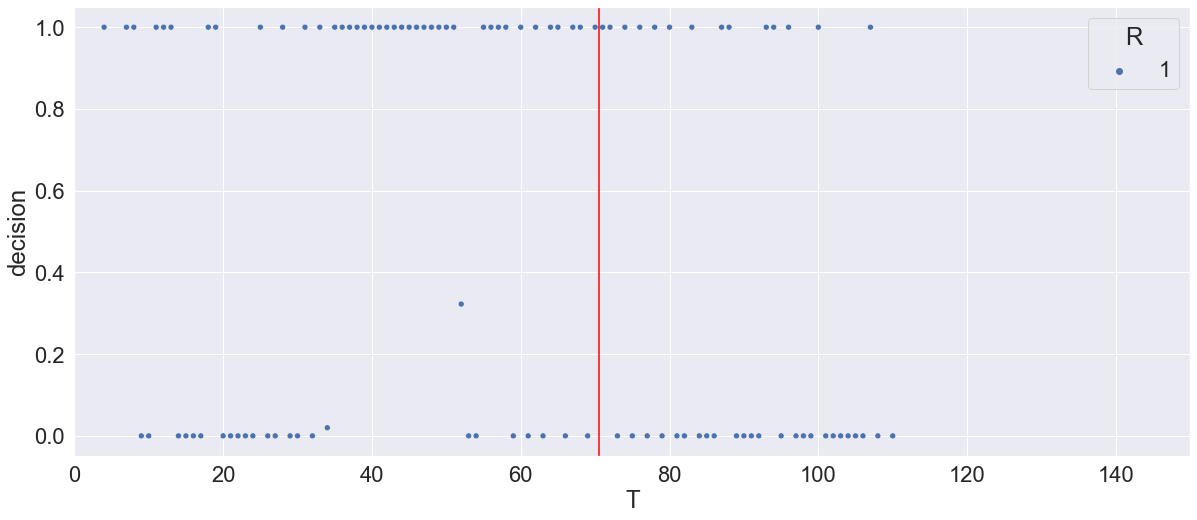

In [202]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==1])
g.set(xlim=(0, 150))
plt.axvline(70.5, 0,1,color='red')


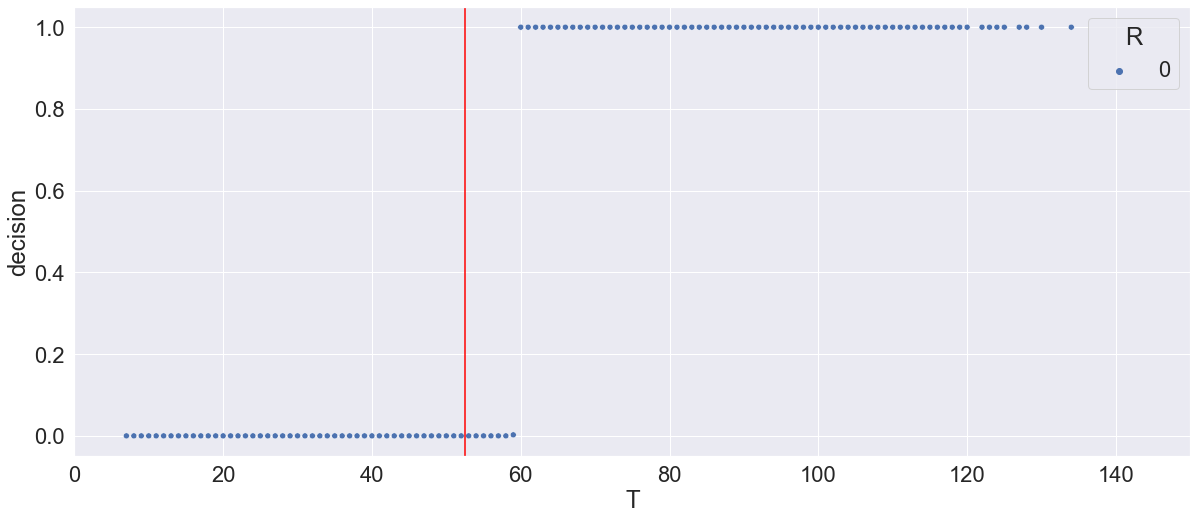

In [203]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)  # crazy big
g = sns.scatterplot(x='T',y='decision',hue='R',data=xxx[xxx['R']==0])
g.set(xlim=(0, 150))
plt.axvline(52.5, 0,1,color='red')



In [204]:
admit_decisions[admit_decisions['decision']==0][['R_x','B_p']].groupby(['R_x']).mean()

,B_p
R_x,
0,0.371738
1,0.406699


In [205]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.533632005909772', '246262.5409999997')

In [206]:
SUM_BP_POLICY/(FRAC_ADMIT*len(df))

A    0.50738
dtype: float64

In [207]:
str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)

('0.533632005909772', '246262.5409999997')

In [208]:
admit_decisions[admit_decisions['decision']==1]['B_p'].mean()

0.5082333605184682

In [209]:
(admit_decisions['decision'] * admit_decisions['ml_outcomes_x']).sum()

311992.13023010874

In [210]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()

246262.5409999997

In [211]:
admit_decisions[admit_decisions['decision']==1]['B_p'].sum()

244908

In [212]:
(admit_decisions['decision'] * admit_decisions['B_p']).sum()/(len(admit_decisions)*FRAC_ADMIT)

A    0.50738
dtype: float64

In [213]:
(admit_decisions['decision'].sum())

485361.00000000006

In [214]:
admit_decisions['rand'] = pd.Series([random.random() for x in range(0,len(admit_decisions))])
admit_decisions['dec_binary'] = admit_decisions['rand'] < admit_decisions['decision']


In [215]:
admit_decisions[admit_decisions['dec_binary']==0][['R_x','B_p']].groupby(['R_x']).mean()

,B_p
R_x,
0,0.380992
1,0.381365


In [216]:
admit_decisions['R_x'].value_counts()

0    669968
1    330032
Name: R_x, dtype: int64